In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms as TF
from torchvision import datasets
import torchvision.models as models
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from time import time
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image


In [2]:
#MODIFIED CITYSCAPES DATASET: ORIGINALLY FROM TORCHVISION SOURCE CODE GITHUB
#https://github.com/pytorch/vision/blob/master/torchvision/datasets/cityscapes.py
#MODIFIED TO INCLUDE ALBUMENTATION AUGMENTATIONS INTO PIPELINE

#For Cityscapes Dataset
import json
import os
from collections import namedtuple
import zipfile
#from .utils import extract_archive, verify_str_arg, iterable_to_str
#from .vision import VisionDataset
from PIL import Image

#For VisionDataset
import torch
import torch.utils.data as data

#For Util Functions
import os.path
import hashlib
import gzip
import errno
import tarfile
from torch.utils.model_zoo import tqdm

#For added albumentation augmentations
from albumentations import (GaussianBlur, RandomFog, HorizontalFlip, RandomSnow, Compose, OneOf)

#Helper function for VisionDataset
def extract_archive(from_path, to_path=None, remove_finished=False):
    if to_path is None:
        to_path = os.path.dirname(from_path)

    if _is_tar(from_path):
        with tarfile.open(from_path, 'r') as tar:
            tar.extractall(path=to_path)
    elif _is_targz(from_path) or _is_tgz(from_path):
        with tarfile.open(from_path, 'r:gz') as tar:
            tar.extractall(path=to_path)
    elif _is_tarxz(from_path):
        with tarfile.open(from_path, 'r:xz') as tar:
            tar.extractall(path=to_path)
    elif _is_gzip(from_path):
        to_path = os.path.join(to_path, os.path.splitext(os.path.basename(from_path))[0])
        with open(to_path, "wb") as out_f, gzip.GzipFile(from_path) as zip_f:
            out_f.write(zip_f.read())
    elif _is_zip(from_path):
        with zipfile.ZipFile(from_path, 'r') as z:
            z.extractall(to_path)
    else:
        raise ValueError("Extraction of {} not supported".format(from_path))

    if remove_finished:
        os.remove(from_path)

#Helper function for VisionDataset
def iterable_to_str(iterable):
    return "'" + "', '".join([str(item) for item in iterable]) + "'"

#Helper function for VisionDataset
def verify_str_arg(value, arg=None, valid_values=None, custom_msg=None):
    if not isinstance(value, torch._six.string_classes):
        if arg is None:
            msg = "Expected type str, but got type {type}."
        else:
            msg = "Expected type str for argument {arg}, but got type {type}."
        msg = msg.format(type=type(value), arg=arg)
        raise ValueError(msg)

    if valid_values is None:
        return value

    if value not in valid_values:
        if custom_msg is not None:
            msg = custom_msg
        else:
            msg = ("Unknown value '{value}' for argument {arg}. "
                   "Valid values are {{{valid_values}}}.")
            msg = msg.format(value=value, arg=arg,
                             valid_values=iterable_to_str(valid_values))
        raise ValueError(msg)

    return value

#Superclass for use with Cityscapes Dataset
class VisionDataset(data.Dataset):
    _repr_indent = 4

    def __init__(self, root, transforms=None, transform=None, target_transform=None):
        if isinstance(root, torch._six.string_classes):
            root = os.path.expanduser(root)
        self.root = root

        has_transforms = transforms is not None
        has_separate_transform = transform is not None or target_transform is not None
        if has_transforms and has_separate_transform:
            raise ValueError("Only transforms or transform/target_transform can "
                             "be passed as argument")

        # for backwards-compatibility
        self.transform = transform
        self.target_transform = target_transform

        if has_separate_transform:
            transforms = StandardTransform(transform, target_transform)
        self.transforms = transforms

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __repr__(self):
        head = "Dataset " + self.__class__.__name__
        body = ["Number of datapoints: {}".format(self.__len__())]
        if self.root is not None:
            body.append("Root location: {}".format(self.root))
        body += self.extra_repr().splitlines()
        if hasattr(self, "transforms") and self.transforms is not None:
            body += [repr(self.transforms)]
        lines = [head] + [" " * self._repr_indent + line for line in body]
        return '\n'.join(lines)

    def _format_transform_repr(self, transform, head):
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def extra_repr(self):
        return ""

#Helper function with VisionDataset to deal with torch transforms
class StandardTransform(object):
    def __init__(self, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

    def __call__(self, input, target):
        if self.transform is not None:
            input = self.transform(input)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return input, target

    def _format_transform_repr(self, transform, head):
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def __repr__(self):
        body = [self.__class__.__name__]
        if self.transform is not None:
            body += self._format_transform_repr(self.transform,
                                                "Transform: ")
        if self.target_transform is not None:
            body += self._format_transform_repr(self.target_transform,
                                                "Target transform: ")

        return '\n'.join(body)

#Albumentations augmentations pipeline
def albumAug(p = 0.5):
    return Compose([
        GaussianBlur(blur_limit=7, always_apply=False, p=p),
        OneOf([
            RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.08, always_apply=False, p=p),
            RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, always_apply=False, p=p),
        ], p=0.5),
        HorizontalFlip(always_apply=False, p=p),
    ], p=1)

#Cityscapes Dataset
class Cityscapes(VisionDataset):
    """`Cityscapes <http://www.cityscapes-dataset.com/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory ``leftImg8bit``
            and ``gtFine`` or ``gtCoarse`` are located.
        split (string, optional): The image split to use, ``train``, ``test`` or ``val`` if mode="fine"
            otherwise ``train``, ``train_extra`` or ``val``
        mode (string, optional): The quality mode to use, ``fine`` or ``coarse``
        target_type (string or list, optional): Type of target to use, ``instance``, ``semantic``, ``polygon``
            or ``color``. Can also be a list to output a tuple with all specified target types.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    Examples:
        Get semantic segmentation target
        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='train', mode='fine',
                                 target_type='semantic')
            img, smnt = dataset[0]
        Get multiple targets
        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='train', mode='fine',
                                 target_type=['instance', 'color', 'polygon'])
            img, (inst, col, poly) = dataset[0]
        Validate on the "coarse" set
        .. code-block:: python
            dataset = Cityscapes('./data/cityscapes', split='val', mode='coarse',
                                 target_type='semantic')
            img, smnt = dataset[0]
    """

    # Based on https://github.com/mcordts/cityscapesScripts
    CityscapesClass = namedtuple('CityscapesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                     'has_instances', 'ignore_in_eval', 'color'])

    classes = [
        CityscapesClass('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
        CityscapesClass('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
        CityscapesClass('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
        CityscapesClass('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
        CityscapesClass('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
        CityscapesClass('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
        CityscapesClass('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
        CityscapesClass('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
        CityscapesClass('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
        CityscapesClass('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
        CityscapesClass('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
        CityscapesClass('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
        CityscapesClass('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
        CityscapesClass('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
        CityscapesClass('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
        CityscapesClass('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
        CityscapesClass('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
        CityscapesClass('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
        CityscapesClass('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
        CityscapesClass('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
        CityscapesClass('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
        CityscapesClass('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
        CityscapesClass('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
        CityscapesClass('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
        CityscapesClass('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
        CityscapesClass('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
        CityscapesClass('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
        CityscapesClass('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
        CityscapesClass('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
        CityscapesClass('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
        CityscapesClass('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
    ]

    def __init__(self, root, split='train', mode='fine', target_type='instance',
                 transform=None, target_transform=None, transforms=None):
        super(Cityscapes, self).__init__(root, transforms, transform, target_transform)
        self.mode = 'gtFine' if mode == 'fine' else 'gtCoarse'
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, self.mode, split)
        self.target_type = target_type
        self.split = split
        self.images = []
        self.targets = []
        self.albumAugs=albumAug() # ADDED: For albumentations augmentation pipeline

        verify_str_arg(mode, "mode", ("fine", "coarse"))
        if mode == "fine":
            valid_modes = ("train", "test", "val")
        else:
            valid_modes = ("train", "train_extra", "val")
        msg = ("Unknown value '{}' for argument split if mode is '{}'. "
               "Valid values are {{{}}}.")
        msg = msg.format(split, mode, iterable_to_str(valid_modes))
        verify_str_arg(split, "split", valid_modes, msg)

        if not isinstance(target_type, list):
            self.target_type = [target_type]
        [verify_str_arg(value, "target_type",
                        ("instance", "semantic", "polygon", "color"))
         for value in self.target_type]

        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):

            if split == 'train_extra':
                image_dir_zip = os.path.join(self.root, 'leftImg8bit{}'.format('_trainextra.zip'))
            else:
                image_dir_zip = os.path.join(self.root, 'leftImg8bit{}'.format('_trainvaltest.zip'))

            if self.mode == 'gtFine':
                target_dir_zip = os.path.join(self.root, '{}{}'.format(self.mode, '_trainvaltest.zip'))
            elif self.mode == 'gtCoarse':
                target_dir_zip = os.path.join(self.root, '{}{}'.format(self.mode, '.zip'))

            if os.path.isfile(image_dir_zip) and os.path.isfile(target_dir_zip):
                extract_archive(from_path=image_dir_zip, to_path=self.root)
                extract_archive(from_path=target_dir_zip, to_path=self.root)
            else:
                raise RuntimeError('Dataset not found or incomplete. Please make sure all required folders for the'
                                   ' specified "split" and "mode" are inside the "root" directory')

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                target_types = []
                for t in self.target_type:
                    target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0],
                                                 self._get_target_suffix(self.mode, t))
                    target_types.append(os.path.join(target_dir, target_name))

                self.images.append(os.path.join(img_dir, file_name))
                self.targets.append(target_types)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise target is a json object if target_type="polygon", else the image segmentation.
        """

        image = Image.open(self.images[index]).convert('RGB')

        targets = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])

            targets.append(target)

        target = tuple(targets) if len(targets) > 1 else targets[0]
        
        #ADDED: Albumentations Augmentations
        if self.split == 'train':
            #Turn image, label into numpy array
            image = np.array(image).astype(np.uint8)
            target = np.array(target).astype(np.uint8)
            
            #Do albumentations augmentations
            data = {'image': image, 'mask':target}
            augmented = self.albumAugs(**data)
            image, target = augmented['image'], augmented['mask']
            
            #Convert back to PIL Image for pytorch augmentations
            image, target = Image.fromarray(image), Image.fromarray(target)
        
        #Pytorch Augmentations
        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.images)

    def extra_repr(self):
        lines = ["Split: {split}", "Mode: {mode}", "Type: {target_type}"]
        return '\n'.join(lines).format(**self.__dict__)

    def _load_json(self, path):
        with open(path, 'r') as file:
            data = json.load(file)
        return data

    def _get_target_suffix(self, mode, target_type):
        if target_type == 'instance':
            return '{}_instanceIds.png'.format(mode)
        elif target_type == 'semantic':
            return '{}_labelIds.png'.format(mode)
        elif target_type == 'color':
            return '{}_color.png'.format(mode)
        else:
            return '{}_polygons.json'.format(mode)

In [3]:
#TRANSFORMS, DATASETS, DATALOADERS

#PYTORCH TRANSFORMS
def trainAugX():
    p=0.5
    return TF.Compose([
        TF.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0),
        TF.Resize(size = (512,1024), interpolation=0),
        TF.ToTensor(),
    ])
def trainElse():
    return TF.Compose([TF.Resize(size = (512,1024), interpolation=0), TF.ToTensor(),])

totensor = trainElse()
trainTransformX = trainAugX()

#Read in datasets: train, validation, test
trainData = Cityscapes('../kruelle/kruelle', split='train', mode='fine', 
                    target_type='semantic', transform=trainTransformX, 
                              target_transform=totensor, transforms=None)
valData = Cityscapes('../kruelle/kruelle', split='val', mode='fine', 
                    target_type='semantic', transform=totensor, 
                              target_transform=totensor, transforms=None)
testData = Cityscapes('../kruelle/kruelle', split='test', mode='fine', 
                    target_type='semantic', transform=totensor, 
                               target_transform=totensor, transforms=None)

#Put into dataloaders
trainLoader = DataLoader(trainData, batch_size=8, shuffle=True)
valLoader = DataLoader(valData, batch_size=5, shuffle=False)
testLoader = DataLoader(testData, batch_size=5, shuffle=False)

In [4]:
#Finding correct directories for use
os.listdir('../kruelle/kruelle')

['gtFine',
 'README',
 'multimnistm2nist.zip',
 'leftImg8bit',
 'gtFine_trainvaltest.zip',
 'license.txt',
 'leftImg8bit_trainvaltest.zip',
 'numbers_data']

In [5]:
# TAKEN FROM CITYSCAPE GITHUB -- TRIMMED, NOT MODIFIED
## https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

from __future__ import print_function, absolute_import, division
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,       19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,       19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,       19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,       19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,       19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,       19 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,       19 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,       19 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,       19 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,       19 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,       19 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,       19 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,       19 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,       19 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,       19 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# Please refer to the main method below for example usages!

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

torch.Size([8, 3, 512, 1024]) torch.Size([8, 1, 512, 1024])


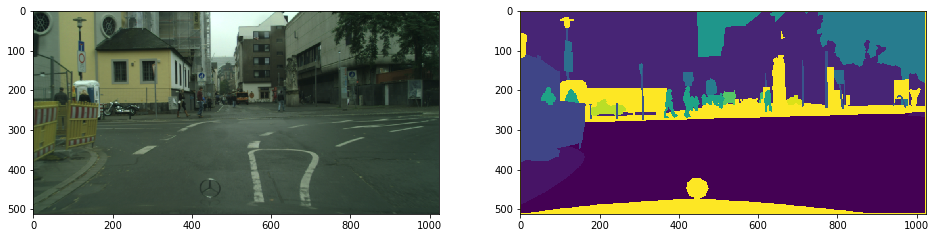

In [7]:
#DATA VISUALIZATION

#Get data
dataiter = iter(trainLoader)
imgs, lbls = dataiter.next()

#Convert labels to correct 1-20
lbls = (lbls*255).type(torch.LongTensor)
for i in range(34):
    lbls[lbls == i] = id2label[i].trainId+50
lbls = lbls-50

#Get image, label shapes
print(imgs.shape, lbls.shape)

#Put image, label in format to be viewed
im2display = imgs[0].numpy().transpose((1,2,0))
lb2display = torch.squeeze(lbls[0]).numpy()

#View image, label in matplotlib
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2, figsize=(16,10))
ax1.imshow(im2display)
ax2.imshow(lb2display)

In [ ]:
#DEFINE UNET MODEL
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool4 = nn.MaxPool2d(4)
        self.maxpool2 = nn.MaxPool2d(2)
        self.firstdropout = nn.Dropout2d(p=0.125)
        self.dropout = nn.Dropout2d(p=0.25)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool4(conv1)
        x = self.firstdropout(x)

        conv2 = self.dconv_down2(x)
        x = self.maxpool4(conv2)
        x = self.dropout(x)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool2(conv3)  
        x = self.dropout(x)
        
        x = self.dconv_down4(x)
        
        x = self.upsample2(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dropout(x)
        
        x = self.dconv_up3(x)
        x = self.upsample4(x)        
        x = torch.cat([x, conv2], dim=1)   
        x = self.dropout(x)

        x = self.dconv_up2(x)
        x = self.upsample4(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dropout(x)
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [ ]:
#Accuracy (IoU) Metric
def iou(pred, target, n_classes = 20):
  ious = []
  pred = pred.view(-1)
  target = target.view(-1)

  for cls in range(n_classes):  
    pred_inds = pred == cls
    target_inds = target == cls
    intersection = (pred_inds[target_inds]).long().sum().data.cpu()  # Cast to long to prevent overflows
    union = pred_inds.long().sum().data.cpu() + target_inds.long().sum().data.cpu() - intersection
    if union == 0:
      ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / float(max(union, 1)))
  return np.array(ious)

In [ ]:
#MAKE UNET MODEL
model = UNet(20)
device = 'cuda:0'
model.to(device)

In [ ]:
#MAKE DEEPLABV3 MODEL
model = models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=20, aux_loss=None)
device = 'cuda:0'
model.to(device)

In [ ]:
#OR LOAD MODEL
#model_name = 'CityscapeUnetModel'
#model_name = 'CityscapesDeeplabModel'
model_name = 'CityscapesDeeplabModel2'
model = torch.load(model_name)
device = 'cuda:0'
model.to(device)
model.eval()

In [ ]:
writer = SummaryWriter()

In [ ]:
#TRAIN MODEL

#TODO: Turn this into a function

#model_name = 'CityscapeUnetModel'
model_name = 'CityscapesDeeplabModel2'
val_loss_least = 1000
model.train()# put model in train mode
criterion = torch.nn.CrossEntropyLoss() #Define loss function
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.99) #define backpropogation function
#optimizer = optim.RMSprop(model.parameters(),lr=0.01,alpha=0.99) # Define the learning function
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0) #10
#optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
epochs = 20 #Num epochs
time0 = time() #initialize time
for e in range(epochs): #Train over e epochs
    running_loss=0 #Init running loss for train data
    running_val_loss=0 #Init running loss for validation data
#    preds_test = torch.zeros((2975,1024,2048)) #For use in IoU accuracy of test data
#    gts_test = torch.zeros((2975,1024,2048)) #For use in IoU accuracy of test data
    preds_val = torch.zeros((500,512,1024)) #For use in IoU accuracy of validation data
    gts_val = torch.zeros((500,512,1024)) #For use in IoU accuracy of validation data #20
    model.train() # Set model to train mode
    for i,(x,y) in enumerate(trainLoader): #Do for each batch in dataloader
        x = x.to(device) # Send inputs to GPU
        y = torch.squeeze((y*255).type(torch.LongTensor))
#        gts_test[i:i+2, :, :] = y #copy y data for use in IoU
        y = y.to(device) #send labels to GPU
        for k in range(34):
            y[y == k] = id2label[k].trainId+50
        y = y-50 #30
        if (y.shape[0] == 1024):
            y = torch.unsqueeze(y, 0)
        #print(output.shape, y.shape)
        optimizer.zero_grad() #Zero the gradients on the optimizer
        output = model(x)['out'] #Get output from the model
        loss = criterion(output,y) #Calculate loss
        loss.backward() #Backpropogation on loss
        optimizer.step() #Learn from loss
#        _,pred = torch.max(output, 1) #Get output in correct format for IoU
#        preds_test[i:i+2, :, :] = pred.cpu() #Send back to CPU and copy for use in IoU #40
        writer.add_scalar('loss/training_per_minibatch', loss.item(), 2975/8*(e)+i) #Write loss to tensorboard per minibatch
        running_loss+=loss.item() #Track runningloss for epoch avg
        if (i%25 == 24): print("{}%".format((100*(i+1))//(2975//(8))))
    print("Epoch {} - Training loss: {}".format(e,running_loss/(2975/8))) #Prints epoch running loss
    writer.add_scalar('loss/training_per_epoch', running_loss/(2975/8), e) #Write epoch avg loss to tensorboard
    print("        - Time Since Start (in minutes) = ",(time()-time0)/60)
    model.eval() # Set model to eval mode
    for j,(x,y) in enumerate(valLoader): #Do for each batch in dataloader
        x = x.to(device) #Send inputs to GPU
        y = torch.squeeze((y*255).type(torch.LongTensor))
        y = y.to(device) #Send labels to device
        for k in range(34):
            y[y == k] = id2label[k].trainId+50
        y = y-50
        if (y.shape[0] == 1024):
            y = torch.unsqueeze(y, 0)
        gts_val[2*j:2*(j+1), :, :] = y.cpu() #copy labels for use in IoU
        optimizer.zero_grad() #Zero the gradients
        output = model(x)['out'] #Get output from model
        loss = criterion(output,y) #Calculate the loss
        _,pred = torch.max(output, 1) #Get output in correct format for IoU use
        preds_val[2*j:2*(j+1), :, :] = pred.cpu() #Send back to CPU and copy for use in IoU
        running_val_loss+=loss.item() #Keep track of running loss for epoch avg
    writer.add_scalar('loss/validation_per_epoch',running_val_loss/(500/2),e) #Write epoch avg loss to tensorboard
#    test_acc = iou(preds_test,gts_test) # Get IoU accuracy for test data
#    test_acc_avg = np.average(test_acc) #Avgerage it over digit classes
#    writer.add_scalar('accuracy/training', test_acc_avg, e) #Write it to tensorboard
    print("        - Validation Loss: {}".format(running_val_loss/(500/2))) 
    print("        - Time Since Start (in minutes) = ",(time()-time0)/60)
    val_acc = iou(preds_val,gts_val) #Same thing as above
    val_acc_avg = np.average(val_acc)
    writer.add_scalar('accuracy/validation', val_acc_avg, e)
#    print("        - Training Accuracy: {}".format(test_acc_avg))
    print("        - Validation Accuracy: {}".format(val_acc_avg))
    print("        - Time Since Start (in minutes) = ",(time()-time0)/60)
    if (running_val_loss/(500/2) < val_loss_least):
        torch.save(model,model_name)
        val_loss_least = running_val_loss/(500/2)
        
print("\nTraining Time (in minutes) =",(time()-time0)/60) #Prints total training time

In [ ]:
print("Epoch {} - Training loss: {}".format(e,running_loss/(i))) #Prints epoch running loss
print("        - Validation Loss: {}".format(running_val_loss/(500/1))) 
print("\nTraining Time (in minutes) =",(time()-time0)/60) #Prints total training time

In [ ]:
#SAVING THE MODEL:
model_name = 'CityscapeUnetModel'
torch.save(model,model_name)

In [ ]:
#Validation Metrics

#device = 'cuda:0'
#model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
running_test_loss=0
preds_val = torch.zeros((500,512,1024)) #For use in IoU accuracy of validation data
gts_val = torch.zeros((500,512,1024)) #For use in IoU accuracy of validation data #20
time0 = time()
model.eval() #Put model in evaluate mode
for j,(x,y) in enumerate(valLoader): #Do for each batch in dataloader
        x = x.to(device) #Send inputs to GPU
        y = torch.squeeze((y*255).type(torch.LongTensor))
        y = y.to(device) #Send labels to device
        for k in range(34):
            y[y == k] = id2label[k].trainId+50
        y = y-50
        if (y.shape[0] == 1024):
            y = torch.unsqueeze(y, 0)
        gts_val[5*j:5*(j+1), :, :] = y.cpu() #copy labels for use in IoU
        optimizer.zero_grad() #Zero the gradients
        output = model(x)['out'] #Get output from model
        loss = criterion(output,y) #Calculate the loss
        _,pred = torch.max(output, 1) #Get output in correct format for IoU use
        preds_val[5*j:5*(j+1), :, :] = pred.cpu() #Send back to CPU and copy for use in IoU
        running_test_loss+=loss.item() #Keep track of running loss for epoch avg
print("Test Loss: {}".format(running_test_loss/(500/5)))
print("Time so far: {}".format(-(time0-time())/60))
test_accuracy = iou(preds_val, gts_val)
avg_test_acc = np.average(test_accuracy)
print("Test Accuracy: {}".format(avg_test_acc))
print("Time: {}".format(-(time0-time())/60))

In [ ]:
#Visualizing the predictions

testIter = iter(valLoader)

imgs, lbls = testIter.next()

print(imgs.shape, lbls.shape)

imgs = imgs.to(device)
output = model(imgs)['out']
_, prediction = torch.max(output, 1)
print(output.shape, prediction.shape)
lbls = torch.squeeze((lbls*255).type(torch.LongTensor))
for k in range(34):
    lbls[lbls == k] = id2label[k].trainId+50
lbls = lbls-50
if (lbls.shape[0] == 1024):
    lbls = torch.unsqueeze(lbls, 0)


im2display = imgs.cpu().numpy().transpose((0,2,3,1))
pred2display = prediction.detach().cpu().numpy()
lbl2display = lbls.numpy()

del imgs
del output
del prediction
torch.cuda.empty_cache()

#print(lb2display[200,300])

#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2, figsize=(16,10))
#ax1.imshow(im2display)
#ax2.imshow(lb2display)

fig, axs = plt.subplots(5, 3, figsize=(16,20))
axs[0,0].imshow(im2display[0])
axs[0,0].set_title('Original Image')
axs[0,1].imshow(pred2display[0])
axs[0,1].set_title('Predicted Labels')
axs[0,2].imshow(lbl2display[0])
axs[0,2].set_title('Target Labels')
axs[1,0].imshow(im2display[1])
axs[1,1].imshow(pred2display[1])
axs[1,2].imshow(lbl2display[1])
axs[2,0].imshow(im2display[2])
axs[2,1].imshow(pred2display[2])
axs[2,2].imshow(lbl2display[2])
axs[3,0].imshow(im2display[3])
axs[3,1].imshow(pred2display[3])
axs[3,2].imshow(lbl2display[3])
axs[4,0].imshow(im2display[4])
axs[4,1].imshow(pred2display[4])
axs[4,2].imshow(lbl2display[4])